In [738]:
import numpy as np  # NumPy package for arrays, random number generation, etc
import matplotlib.pyplot as plt  # For plotting
from shapely.geometry import Point
import pandas as pd
from sklearn.neighbors import KDTree

import random_point_processes as rpp

In [739]:
import logging
logging.basicConfig(level=logging.INFO)

DEBUG:root:Starting thomas cluster gen
DEBUG:root:Simulate Poisson point process for the parents
DEBUG:root:Starting random poisson point process
DEBUG:root:Simulate Poisson point process
DEBUG:root:Simulate Poisson point process for the daughters (from 102 centres)
DEBUG:root:Generate the (relative) locations in Cartesian coordinates 1020004
DEBUG:root:replicate parent points (ie centres of disks/clusters)


102 centres. 1020004 households.


(-111.17908510393798,
 1092.2085957745182,
 -88.94166689927043,
 1101.0697918981073)

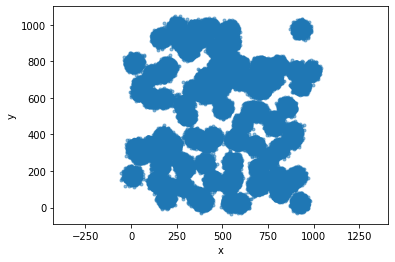

In [784]:
xx, yy, xx_parent_repeated, yy_parent_repeated, xx_parent, yy_parent, centre_ids = rpp.thomas_cluster_process(
    xmin = 0,
    xmax = 1000,
    ymin = 0,
    ymax = 1000,
    lambda_parent = .0001, # density of parent Poisson point process
    lambda_daughter = 10000, # mean number of points in each cluster
    sigma = 15 # sigma for normal variables (ie random locations) of daughters
)
print(len(xx_parent), 'centres.', len(xx), 'households.')
plt.scatter(xx, yy, alpha=0.5, marker='.')
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')

In [786]:
pop_size = len(xx)
pop_size

1020004

In [787]:
def minmax(array):
    assert isinstance(array, np.ndarray)
    return (array - min(array)) / (max(array) - min(array))

In [788]:
# build some hidden features

In [789]:
pop_locs = [Point(x, y) for x, y in zip(xx,yy)]

In [790]:
pop_centres = [Point(x, y) for x, y in zip(xx_parent, yy_parent)]
centres = [Point(x, y) for x, y in zip(xx_parent_repeated, yy_parent_repeated)]

In [791]:
dist_to_centre = np.array([x.distance(y) for x, y in zip(pop_locs, centres)])

In [792]:
loc_array = np.vstack((xx, yy)).T
centre_array = np.vstack((xxParent, yyParent)).T

In [793]:
tree = KDTree(centre_array)

In [830]:
dist_closest_centre, _ = tree.query(loc_array, dualtree=True, k=1)
dist_closest_centre = dist_closest_centre.reshape(-1)
dist_closest_centre_mm = minmax(dist_closest_centre)
len(dist_closest_centre_mm)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


1020004

In [795]:
nearest_dist, _ = tree.query(loc_array, dualtree=True, k=3)
dist_closest_centres = nearest_dist.sum(axis=1)
dist_closest_centres_mm = minmax(dist_closest_centres)
len(dist_closest_centres_mm)

1020004

In [796]:
tree = KDTree(loc_array)
density = tree.query_radius(loc_array, count_only=True, r=1)
density_mm = minmax(density)
len(density_mm)

1020004

In [797]:
xx_mm = minmax(xx)
yy_mm = minmax(yy)
dist_to_centre_mm = minmax(dist_to_centre)
centre_ids_mm = minmax(centre_ids)

In [798]:
# build some attributes based on these hidden features and on each other

In [799]:
def get_gender(pman=.49, n=4):
    return np.random.choice([0, 1], size=n, p=[pman, 1-pman])

In [800]:
genders = get_gender(n=pop_size)

In [801]:
def get_ethnicity(xx, yy, density):
    p1 = np.random.poisson(xx*10)
    p2 = np.random.poisson(density*10)
    p3 = np.random.poisson(density*xx*10)
    p4 = np.random.poisson(((xx - .5)*10)**2)
    p5 = np.random.poisson(yy*10)
    choice = np.array([p1,p2,p3,p4,p5])
    choice = choice/sum(choice)
    return np.random.choice([1,2,3,4,5], p=choice)
    

In [802]:
ethnicity = np.array([get_ethnicity(x,y,d) for x,y,d in zip(xx_mm, yy_mm, density)])

In [803]:
def get_hh_people(ethnicity, density):
    p1 = density*50 + ethnicity*2
    p2 = density*40 + ethnicity*4
    p3 = density*30 + ethnicity*6
    p4 = density*20 + ethnicity*8
    p5 = density*10 + ethnicity*10
    choice = np.array([p1,p2,p3,p4,p5])
    choice = choice/sum(choice)
    return np.random.choice([1,2,3,4,5], p=choice)

In [804]:
hh_people = np.array([get_hh_people(e,d) for e,d in zip(ethnicity, density)])

In [805]:
def get_age(centre_id, density, dist_closest_centre):
    old = 70
    adult = 30 + (12*centre_id)
    child = 20 - (12*centre_id)
    return np.random.choice(
        [
            int(np.random.poisson(old)),
            int(np.random.poisson(adult)),
            int(np.random.poisson(child))
        ],
        p=(.3-(density*dist_closest_centre/5),.3,.4+(density*dist_closest_centre/5))
    )

In [806]:
age = np.array([get_age(c,d,dist) for c,d,dist in zip(centre_ids_mm, density_mm, dist_closest_centre_mm)])

In [831]:
def get_dist_pt(dist_closest_centre):
    return np.random.normal(1-dist_closest_centre)**2

In [832]:
dist_pt = np.array([get_dist_pt(d) for d in dist_closest_centre])

In [809]:
def get_income(dist_closest_centres):
    return (15 + np.random.poisson(5*(dist_closest_centres+1))*5)*1000

In [810]:
income = np.array([get_income(d) for d in dist_closest_centres_mm])

In [816]:
income_mm = minmax(income)

In [818]:
def get_car(ethnicity, income_mm, density_mm):
    p = income_mm * (1 - density_mm)
    if ethnicity < 3:
        p /=2 
    choice = np.array([p, 1-p])
    return np.random.choice([1, 0], p=choice)

In [820]:
has_car = np.array([get_car(e, i, d) for e, i, d in zip(ethnicity, income_mm, density_mm)])

In [ ]:
# build df

In [833]:
data_dict =  {
        'x': xx,
        'y': yy,
        'centre_id': centre_ids,
        'dist_centre': dist_to_centre,
        'density': density,
        'gender': genders,
        'ethnicity': ethnicity,
        'hh_people': hh_people,
        'age': age,
        'dist_pt': dist_pt,
        'income': income,
        'has_car': has_car
    }

In [834]:
for k,v in data_dict.items():
    print(k, len(v))

x 1020004
y 1020004
centre_id 1020004
dist_centre 1020004
density 1020004
gender 1020004
ethnicity 1020004
hh_people 1020004
age 1020004
dist_pt 1020004
income 1020004
has_car 1020004


In [835]:
data = pd.DataFrame(data_dict)

In [836]:
data.head()

,x,y,centre_id,dist_centre,density,gender,ethnicity,hh_people,age,dist_pt,income,has_car
0,535.071881,952.859788,0,19.126535,12,0,2,2,36,0.739358,45000,0
1,546.972366,995.682667,0,25.321996,9,0,2,3,22,2.669353,40000,0
2,556.785626,980.505114,0,19.159516,12,0,2,4,69,3.185707,45000,1
3,543.035664,944.165281,0,27.361781,11,1,2,2,22,2.422186,25000,0
4,536.530146,971.336653,0,3.423286,21,1,2,2,18,1.978793,50000,0


In [838]:
data.to_csv('data.csv', index=False)